# This notebook loads trajectories of a Kerr system in the qubit regime and applies machine learning algorithms to learn about the manifold the trajectory spans.

In [1]:
Regime = "kerr_bistable" ## used to load appropraite file

#  loading trajectory and using manifold my diffusion map script.

In [2]:
## load trajectory data from file
import pickle

## diffusion maps
from diffusion_maps import run_diffusion_map

## numerical
import numpy as np

## plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm

In [3]:
def show_colorbar(x_index, name):
    ## show color scheme
    # http://matplotlib.org/examples/color/colormaps_reference.html

    gradient = np.linspace(0, 1, x_index)
    gradient = np.vstack((gradient, gradient))

    fig, axes = plt.subplots(figsize=(24,2))
    axes.set_title( ' colormaps', fontsize=14)
    axes.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))

    plt.show()

In [4]:
def colored_3d_plot(data):
    ## Figure 
    fig = plt.figure(figsize=(24,20))
    ax = fig.add_subplot(111, projection='3d')
    to_plot_=[[x[i] for x in data] for i in xrange(0,3)]

    x_index = len(np.asarray(to_plot_).T)/params['Ntraj']

    color_list = np.concatenate([np.linspace(0, 1, x_index)] * params['Ntraj'])
    colors = cm.jet(color_list)
    ax.scatter(*to_plot_,c=colors)

    show_colorbar(x_index,'jet')

## Diffusion maps

### Old format

In [5]:
# ## load trajectory data from file
# pkl_file = open('./trajectory_data/'+ Regime +'.pkl', 'rb')
# (params,SLH,data_traj) = pickle.load(pkl_file)
# pkl_file.close()

# ## sample 
# traj1 = data_traj[0::100]

### New format

In [6]:
## load trajectory data from file

pkl_file = open('./trajectory_data/pkl_'+ Regime +'.pkl', 'rb')
pkl_dict = pickle.load(pkl_file)
pkl_file.close()

## pre-process expectation values

traj_expects = np.concatenate(pkl_dict['expects']).real.T

## some useful numbers

Ntraj = pkl_dict['Ntraj']
duration = pkl_dict['duration']

##  Extract data into points of format (psi.real,psi.imag) from all trajectories.

traj_data = np.concatenate(
            [[ np.concatenate([f(pkl_dict['psis'][traj_num][time_num]) 
                for f in (lambda x: x.real, lambda x: x.imag) ]) 
                    for traj_num in range(Ntraj)]
                        for time_num in range(int(duration))])

In [7]:
len(traj_data)

100000

In [8]:
## Paramters to use

diffusion_params = {}

diffusion_params["gaussian_epsilon"] = 0.1 ## width of Gaussian kernel.
diffusion_params["num_neighbors"] = 100 ## cutoff of number of neighbors, if using epsilon_cutoff
diffusion_params["alpha"] = 1. ## coefficient to use for diffusion maps. See the wikipedia article.

diffusion_params["data_size"] = 2000 ## total number of points
diffusion_params["eigen_dims"] = 4 ## number of lower dimensions to consider, i.e. number of eigenvectors to find.

In [9]:
traj1 = traj_data[::(len(traj_data)/diffusion_params["data_size"])]
Nfock = pkl_dict['Nfock']

In [10]:
## Using the euclidean (default) metric

e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                   diffusion_params,
                                   symmetric=True,
                                   neighbor_selection = "num_neighbors")

data = e_vecs.T[1:].T

using num_neighbors  


## The shape above resebmles a cone. Let's see how the expectation of the photon number corresopnds to the parts of the cone.

In [11]:
def plot_by_operator(data,traj1,operator = "photon_num"):
    
    if operator == "photon_num":
        num = np.asmatrix(np.diag([i for i in range(Nfock)]*2))
        num_expects = np.asarray([(i*num*i.T)[0,0] for i in np.asmatrix(traj1)])
    else:
        raise ValueError("operator type not implemented")
       
    ## sort data by expected photon number
    num_expects_indices = [(i,n) for i,n in enumerate(num_expects)]
    sorted_num_expects = sorted(num_expects_indices, key = lambda z: z[1])
    data_by_num = [data[i[0]] for i in sorted_num_expects]

    ## Figure 
    fig = plt.figure(figsize=(24,20))
    ax = fig.add_subplot(111, projection='3d')
    to_plot_=[[x[i] for x in data_by_num] for i in xrange(0,3)]

    ## color bar
    x_index = len(np.asarray(to_plot_).T)
    color_list = np.concatenate([np.linspace(0, 1, x_index)] )
    colors = cm.jet(color_list)
    ax.scatter(*np.asarray(to_plot_),c=colors)
    show_colorbar(x_index,'jet')

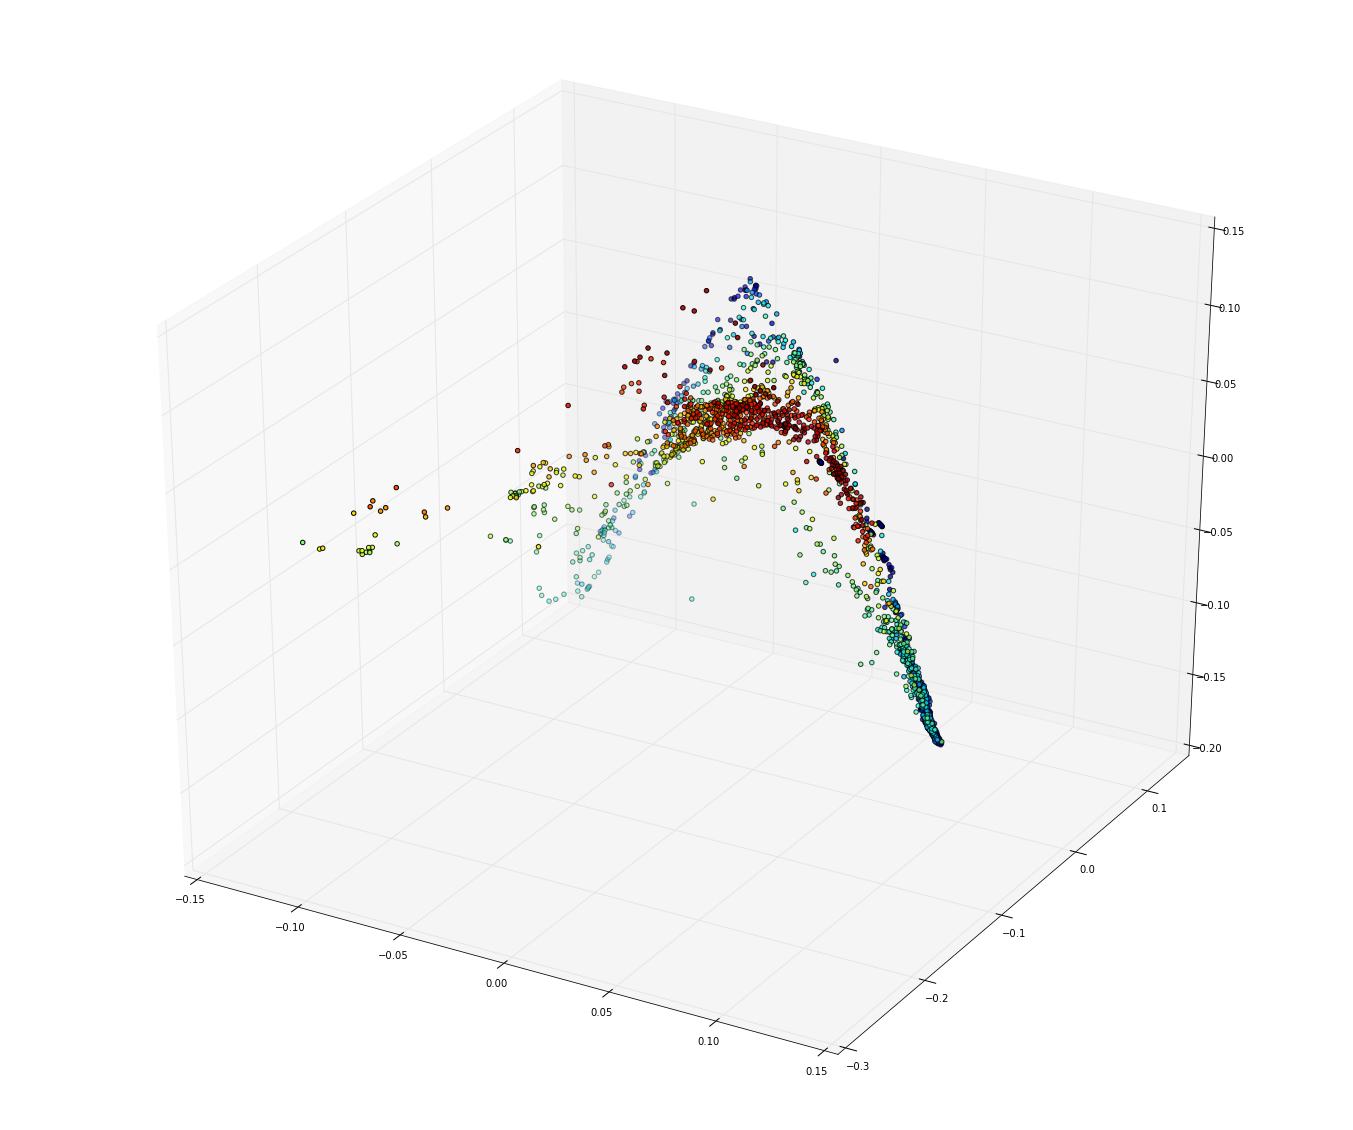

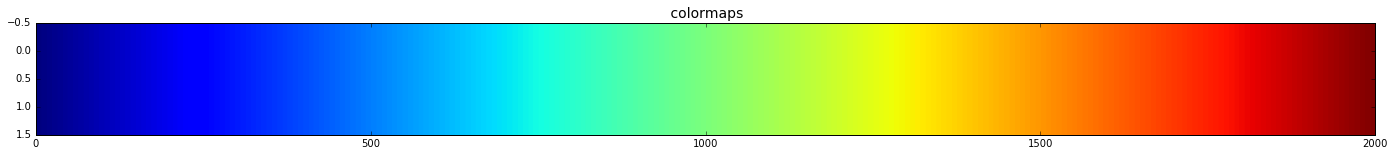

In [12]:
plot_by_operator(data,traj1)

# Fubini-Study metric below!

In [13]:
## Using the euclidean (default) metric
diffusion_params["eigen_dims"] = 4 ## number of lower dimensions to consider, i.e. number of eigenvectors to find.

e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                   diffusion_params,
                                   symmetric=True,
                                   metric = "FS_metric",
                                   neighbor_selection = "num_neighbors")

using num_neighbors  


In [14]:
data = e_vecs.T[1:].T

## Again, let's color by photon number expectation:

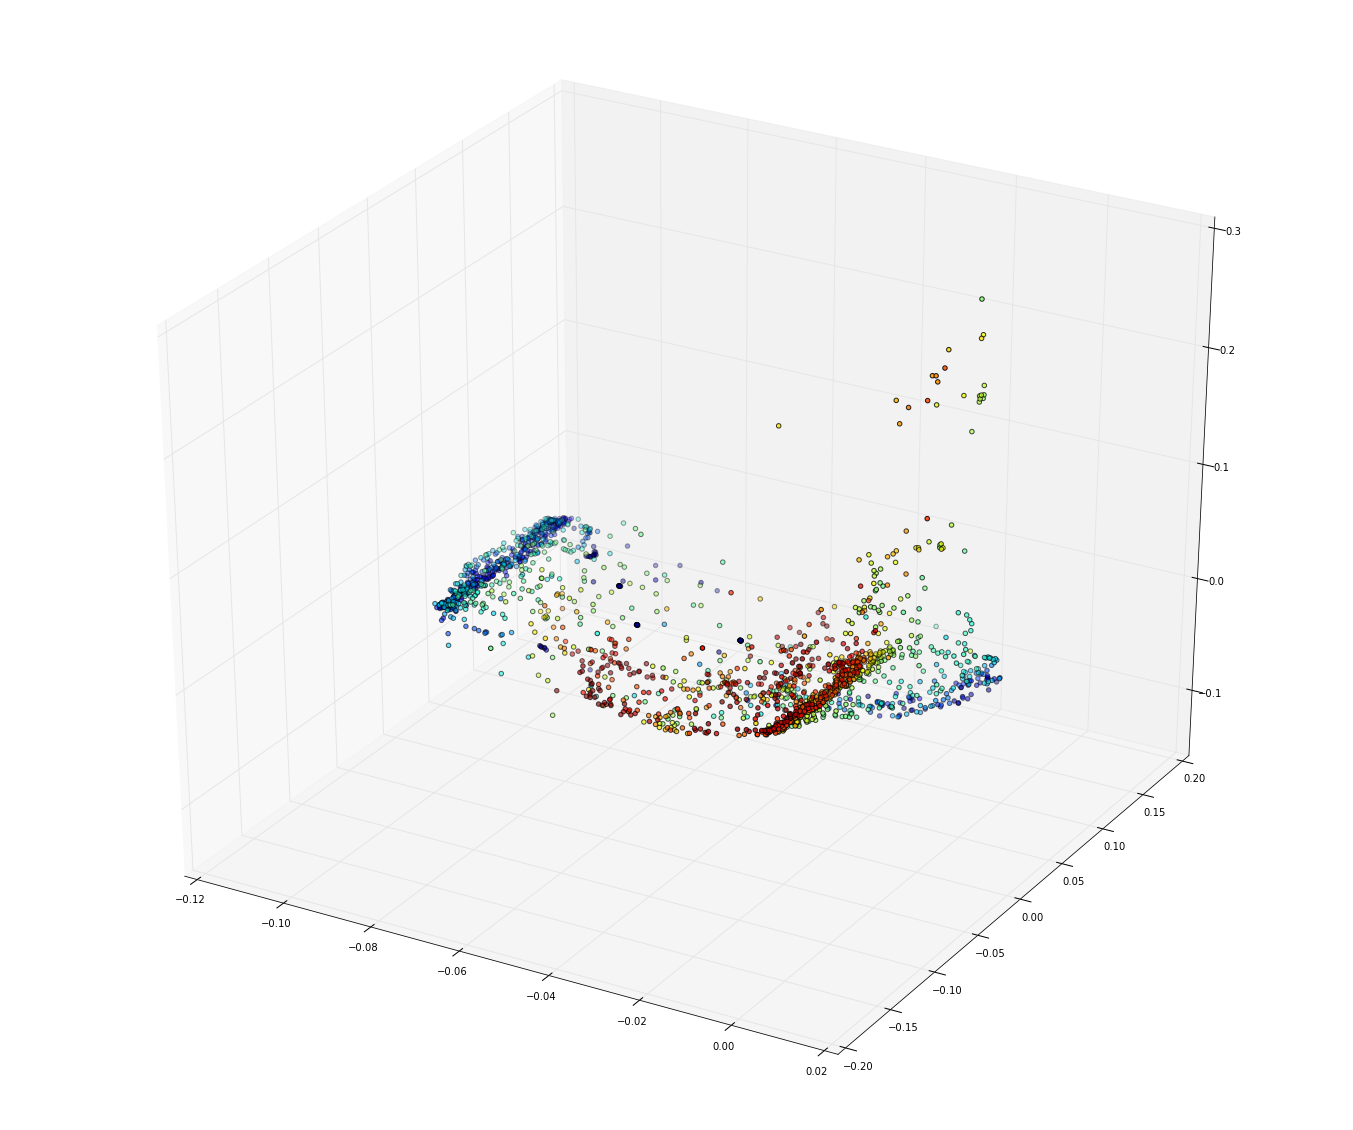

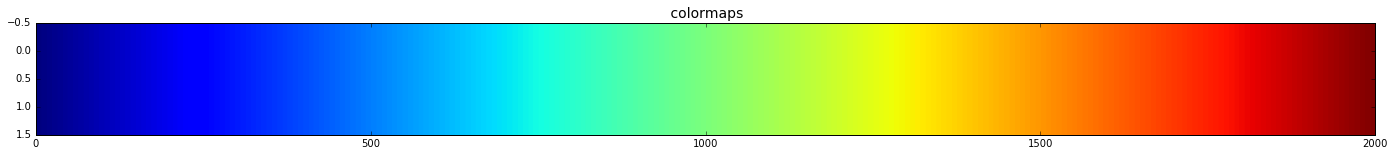

In [15]:
plot_by_operator(data,traj1)